In [1]:
import numpy as np
import librosa
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import matplotlib.pyplot as plt
import IPython
from IPython import display
import os, sys
import pathlib
%matplotlib inline

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art import config
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations.audio_perturbations \
        import CacheToneTrigger, CacheAudioTrigger

AUDIO_DATA_PATH = os.path.join(config.ART_DATA_PATH, "mini_speech_commands/")

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
session = tf.compat.v1.Session()
tf.compat.v1.keras.backend.set_session(session)

In [2]:
data_dir = pathlib.Path(AUDIO_DATA_PATH)
print(data_dir)
if not data_dir.exists():
    tf.keras.utils.get_file(
        str(data_dir)+'/mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_subdir=str(data_dir)
  )

/root/.art/data/mini_speech_commands


In [3]:
commands = np.array(['right', 'go', 'no', 'left', 'stop', 'up', 'down', 'yes'])


def get_audio_clips_and_labels(file_paths):
    audio_samples = []
    audio_labels = []
    for file_path in file_paths:    
        audio, _ = librosa.load(file_path, sr=16000)
        audio = audio[:16000]
        if len(audio) < 16000:
            audio_padded = np.zeros(16000)
            audio_padded[:len(audio)] = audio
            audio = audio_padded
        label = file_path.decode("utf-8").split("/")[-2]
        audio_samples.append(audio)
        audio_labels.append(label)
    return np.stack(audio_samples), np.stack(audio_labels)

def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
                      waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), tf.math.argmax(label == commands)),
      num_parallel_calls=tf.data.AUTOTUNE)


In [4]:
filenames=[]
with tf.compat.v1.Session() as sess:    
    filenames = tf.io.gfile.glob(str(data_dir)+'/mini_speech_commands' + '/*/*')
    filenames = tf.random.shuffle(filenames).eval()
    
train_files = filenames[:6400]
test_files = filenames[-1600:]

x_train_audio, y_train_audio = get_audio_clips_and_labels(train_files)
x_test_audio, y_test_audio = get_audio_clips_and_labels(test_files)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_audio, y_train_audio))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_audio, y_test_audio))

train_dataset = make_spec_ds(train_dataset)
test_dataset = make_spec_ds(test_dataset)

train_dataset = train_dataset.cache().batch(50).shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().batch(50).prefetch(tf.data.AUTOTUNE)



In [5]:
from tensorflow.keras import layers
from tensorflow.keras import models

norm_layer = layers.Normalization()
input_shape = (124, 129, 1)
num_labels = 8
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])

# classifier = TensorFlowV2Classifier(model=model,
#                                     loss_object=loss_object,
#                                     optimizer=optimizer,
#                                     input_shape=(124, 129, 1),
#                                     nb_classes=8)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [6]:
EPOCHS = 10
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)],
)


Train on 128 steps, validate on 32 steps
Epoch 1/10
127/128 [============================>.] - ETA: 0s - batch: 63.0000 - size: 1.0000 - loss: 1.7258 - accuracy: 0.3835

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


128/128 [==============================] - 9s 51ms/step - batch: 63.5000 - size: 1.0000 - loss: 1.7238 - accuracy: 0.3842 - val_loss: 1.2886 - val_accuracy: 0.6131
Epoch 2/10
128/128 [==============================] - 6s 37ms/step - batch: 63.5000 - size: 1.0000 - loss: 1.1716 - accuracy: 0.5861 - val_loss: 0.9040 - val_accuracy: 0.7131
Epoch 3/10
128/128 [==============================] - 6s 37ms/step - batch: 63.5000 - size: 1.0000 - loss: 0.8943 - accuracy: 0.6897 - val_loss: 0.7753 - val_accuracy: 0.7475
Epoch 4/10
128/128 [==============================] - 6s 38ms/step - batch: 63.5000 - size: 1.0000 - loss: 0.7211 - accuracy: 0.7494 - val_loss: 0.6520 - val_accuracy: 0.7937
Epoch 5/10
128/128 [==============================] - 6s 38ms/step - batch: 63.5000 - size: 1.0000 - loss: 0.6142 - accuracy: 0.7836 - val_loss: 0.6097 - val_accuracy: 0.8025
Epoch 6/10
128/128 [==============================] - 6s 38ms/step - batch: 63.5000 - size: 1.0000 - loss: 0.5407 - accuracy: 0.8075 - v

In [7]:
def get_spectrogram_ne(audio):
    waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
    spectrogram = tf.signal.stft(
                      waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


def audio_clips_to_spectrograms_ne(audio_clips):
    spectrogram_samples = []
    for i, audio in enumerate(audio_clips):
        spectrogram = get_spectrogram_ne(audio)
        spectrogram_samples.append(spectrogram)
    return tf.stack(spectrogram_samples).eval()
x_test = []

with session.as_default():
    x_test = audio_clips_to_spectrograms_ne(x_test_audio)


In [8]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.evaluations.security_curve import SecurityCurve

classifier = KerasClassifier(model=model, clip_values=(0, 1))
ART_EPS = 0.1
attack_fgsm = FastGradientMethod(estimator=classifier, eps=ART_EPS)
x_test_adv = attack_fgsm.generate(x_test)


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [9]:
y_test = np.array([np.argmax(label == commands) for label in y_test_audio])

loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on benign test data: {:4.2f}%'.format(accuracy_test * 100))

loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on benign test data: 85.12%
Accuracy on adversarial test data: 14.88%
Average perturbation: 0.02


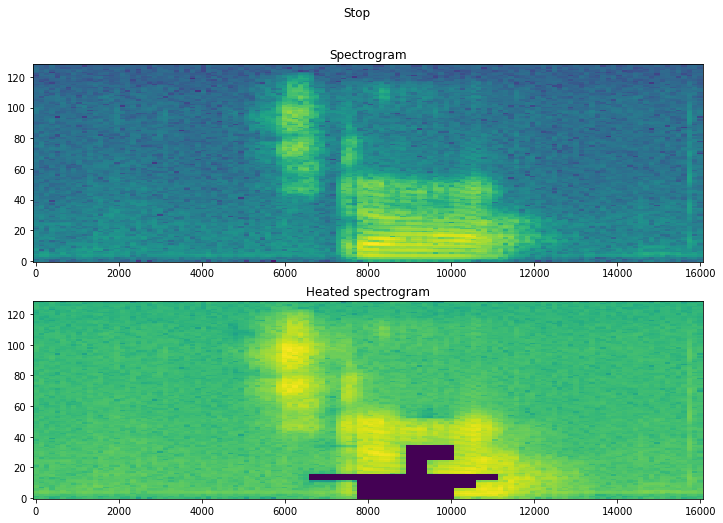

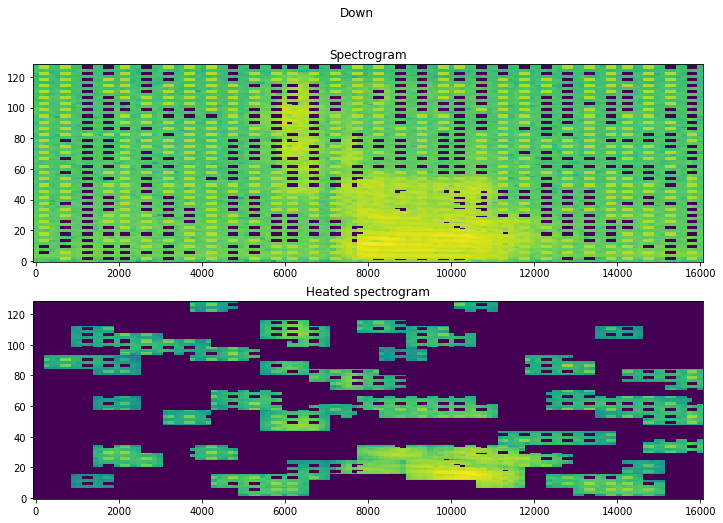

orig perturbation 0.018161189
interpretation perturbation 0.051822685


In [12]:
def get_waveform_ne(audio):
    spectrogram = tf.convert_to_tensor(audio, dtype=tf.complex64)
    spectrogram = tf.squeeze(spectrogram, [2])
    window_fn = tf.signal.inverse_stft_window_fn(128, forward_window_fn = tf.signal.hamming_window)
    waveform = tf.signal.inverse_stft(
                      spectrogram, frame_length=255, frame_step=128, window_fn = window_fn)
    return waveform


def spectrograms_to_waveforms_ne(spectrograms):
    waveforms = []
    for i, spectgrogram in enumerate(spectrograms):
        waveform = get_waveform_ne(audio)
        waveforms.append(waveform)
    return tf.stack(waveforms).eval()

def makeGradCAMHeatmap(spectrogram, model, convLayerName, classIndex=None):
        gradModel = tf.keras.models.Model(model.inputs, [model.get_layer(convLayerName).output, model.output])
        with tf.GradientTape() as tape:
            convLayerOutput, prediction = gradModel(tf.stack([spectrogram]))
            if classIndex is None:
                classIndex = tf.argmax(prediction[0])
            classChannel = prediction[:, classIndex]
        
        grads = tape.gradient(classChannel, convLayerOutput)
        pooledGrads = tf.reduce_mean(grads, axis=(0, 1, 2))

        heatmap = convLayerOutput[0] @ pooledGrads[..., tf.newaxis]
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmap = tf.image.resize(heatmap, (input_shape[0], input_shape[1]))
        return heatmap

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

def compare_perturbation(original, adv, idx):
    heatmapOriginal = makeGradCAMHeatmap(original[idx], model, "conv2d_1")
    heatmapAdv = makeGradCAMHeatmap(adv[idx], model, "conv2d_1")
    print("orig perturbation", tf.reduce_mean(tf.abs(adv - original)).eval())
    print("interpretation perturbation", tf.reduce_mean(tf.abs(heatmapAdv - heatmapOriginal)).eval())

def plot_fair(x_test_adv, idx):
    heatmap = makeGradCAMHeatmap(x_test_adv[idx], model, "conv2d_1")
    heated_waveform = get_waveform_ne(tf.cast(tf.math.multiply(x_test_adv[idx], heatmap), dtype=tf.complex64))

    y_adv = commands[np.argmax(model(tf.stack([x_test_adv[idx]])).eval()[0])]
    plot_some(get_waveform_ne(x_test_adv[idx]).eval(), x_test_adv[idx], y_adv, heatmap.eval(), heated_waveform.eval())

def plot_some(wave_x, spectro_x, y, heatmap, wave_heated):
    label = commands[np.argmax(y == commands)]

    axes = 2
    fig, axes = plt.subplots(axes, figsize=(12, 4*axes))
    timescale = np.arange(wave_x.shape[0])
    ax = 0

#     axes[ax].plot(timescale, wave_x)
#     axes[ax].set_title('Waveform')
#     axes[ax].set_xlim([0, 16000])
#     ax += 1

    plot_spectrogram(spectro_x, axes[ax])
    axes[ax].set_title('Spectrogram')
    ax += 1
    
#     plot_spectrogram(heatmap, axes[ax])
#     axes[ax].set_title('Heatmap')
#     ax += 1
    
    plot_spectrogram(np.multiply(spectro_x, heatmap), axes[ax])
    axes[ax].set_title('Heated spectrogram')
    ax += 1
    
    plt.suptitle(label.title())
    plt.show()
    display.display(display.Audio(wave_x, rate=16000))
    display.display(display.Audio(wave_heated, rate=16000))

with session.as_default():
    plot_fair(x_test, 4)
    plot_fair(x_test_adv, 4)
    compare_perturbation(x_test, x_test_adv, 4)

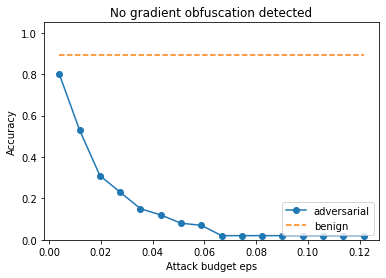

In [13]:
kwargs_pgd = {"norm": "inf",
              "eps_step": 1/255,
              "max_iter": 100,
              "targeted": False,
              "num_random_init": 0,
              "batch_size": 128,
              "random_eps": False,
              "verbose": False,
             }

sc = SecurityCurve(eps=[i / 255 for i in range(1, 32, 2)])
eps_list, accuracy_adv_list, accuracy = sc.evaluate(classifier=classifier,
                                                    x=x_test[0:100],
                                                    y=np.eye(np.max(y_test)+1)[y_test][0:100],
                                                    **kwargs_pgd)
sc.plot()

In [14]:
model_clone = tf.keras.models.clone_model(model, input_tensors = [tf.keras.Input(shape=input_shape, name="clone_input_1")])
model_clone.set_weights(model.get_weights())

for layer in model_clone.layers:
    layer._name = "clone_"+layer._name
    layer.trainable = False

In [15]:
convLayerName = "conv2d_1"
advTrainModelInputs = [model_clone.input, model.input]
subtracted = tf.keras.layers.Subtract()([model.get_layer(convLayerName).output, model_clone.get_layer("clone_"+convLayerName).output])
mse = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(tf.math.pow(x, 2), [1,2,3], keepdims=True))(subtracted)
advTrainModelOutputs = [mse]
advTrainModel = tf.keras.models.Model(advTrainModelInputs, advTrainModelOutputs)

advTrainModel.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 124, 129, 1  0           []                               
                                )]                                                                
                                                                                                  
 clone_input_1 (InputLayer)     [(None, 124, 129, 1  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 32, 32, 1)    0           ['input_1[0][0]']                
                                                                                           

In [16]:
with session.as_default():
    x_train = audio_clips_to_spectrograms_ne(x_train_audio)


In [17]:
x_train_adv = attack_fgsm.generate(x_train)

In [18]:
def generator():
    for i1, i2 in zip(x_train, x_train_adv):
#         yield {"input_1": i1, "clone_input_1": i1}, 0
        yield {"input_1": i1, "clone_input_1": i2}, 0
adv_train_dataset = tf.data.Dataset.from_generator(generator, output_signature=({"input_1": tf.TensorSpec(shape=input_shape, dtype=tf.float64), "clone_input_1": tf.TensorSpec(shape=input_shape, dtype=tf.float64)}, tf.TensorSpec(shape=(), dtype=tf.float64)))
adv_train_dataset = adv_train_dataset.cache().batch(50).shuffle(1000).prefetch(tf.data.AUTOTUNE)


In [19]:
loss_object = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

advTrainModel.compile(optimizer=optimizer, loss=loss_object)

In [20]:
EPOCHS = 10
history = advTrainModel.fit(
    adv_train_dataset,
    epochs=EPOCHS,
)

Train on None steps
Epoch 1/10
128/128 [==============================] - 51s 35ms/step - batch: 63.5000 - size: 1.0000 - loss: 105.3219
Epoch 2/10
128/128 [==============================] - 6s 32ms/step - batch: 63.5000 - size: 1.0000 - loss: 98.9168
Epoch 3/10
128/128 [==============================] - 6s 33ms/step - batch: 63.5000 - size: 1.0000 - loss: 98.1971
Epoch 4/10
128/128 [==============================] - 6s 33ms/step - batch: 63.5000 - size: 1.0000 - loss: 97.8861
Epoch 5/10
128/128 [==============================] - 6s 32ms/step - batch: 63.5000 - size: 1.0000 - loss: 97.6275
Epoch 6/10
128/128 [==============================] - 7s 33ms/step - batch: 63.5000 - size: 1.0000 - loss: 97.4997
Epoch 7/10
128/128 [==============================] - 6s 32ms/step - batch: 63.5000 - size: 1.0000 - loss: 97.4178
Epoch 8/10
128/128 [==============================] - 6s 32ms/step - batch: 63.5000 - size: 1.0000 - loss: 97.3500
Epoch 9/10
128/128 [==============================] - 7s 3

In [21]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on benign test data: {:4.2f}%'.format(accuracy_test * 100))

loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
print('Accuracy on old adversarial test data: {:4.2f}%'.format(accuracy_test * 100))


Accuracy on benign test data: 67.00%
Accuracy on old adversarial test data: 26.12%


In [22]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))

attack_fgsm = FastGradientMethod(estimator=classifier, eps=ART_EPS)

x_test_adv_new = attack_fgsm.generate(x_test)

In [23]:
loss_test, accuracy_test = model.evaluate(x_test_adv_new, y_test)
print('Accuracy on new adversarial test data: {:4.2f}%'.format(accuracy_test * 100))

perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on new adversarial test data: 24.88%
Average perturbation: 0.02


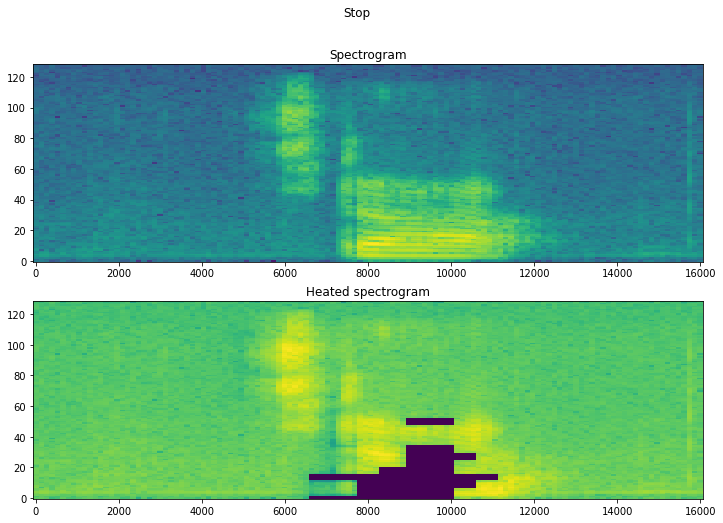

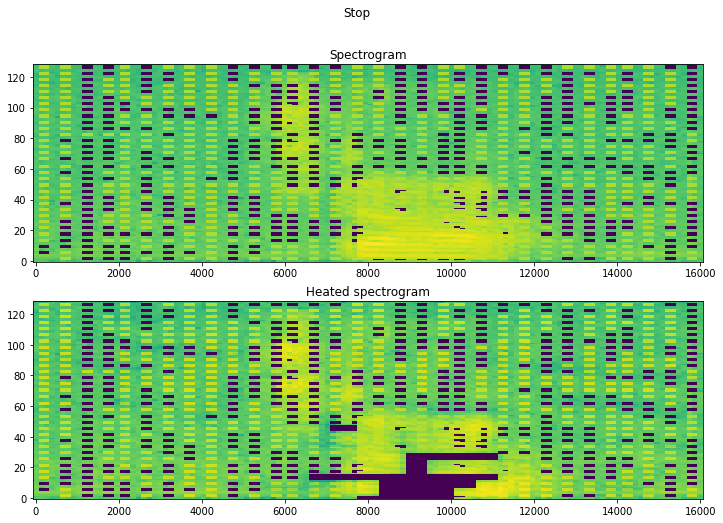

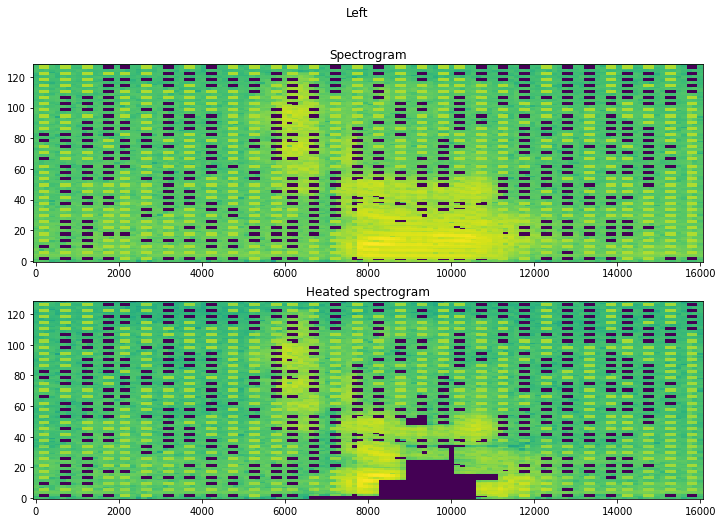

orig perturbation 0.018161189
interpretation perturbation 0.03324352
orig perturbation 0.017852372
interpretation perturbation 0.03073647


In [24]:
with session.as_default():
    plot_fair(x_test, 4)
    plot_fair(x_test_adv, 4)
    plot_fair(x_test_adv_new, 4)
    compare_perturbation(x_test, x_test_adv, 4)
    compare_perturbation(x_test, x_test_adv_new, 4)
    

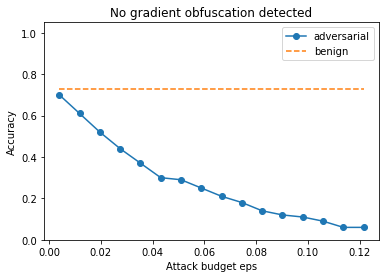

In [25]:
kwargs_pgd = {"norm": "inf",
              "eps_step": 1/255,
              "max_iter": 100,
              "targeted": False,
              "num_random_init": 0,
              "batch_size": 128,
              "random_eps": False,
              "verbose": False,
             }

sc = SecurityCurve(eps=[i / 255 for i in range(1, 32, 2)])
eps_list, accuracy_adv_list, accuracy = sc.evaluate(classifier=classifier,
                                                    x=x_test[0:100],
                                                    y=np.eye(np.max(y_test)+1)[y_test][0:100],
                                                    **kwargs_pgd)
sc.plot()

In [26]:
train_dataset_adv = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_train_adv, dtype=tf.float64), np.array([np.argmax(label == commands) for label in y_train_audio])))
train_dataset_adv = train_dataset_adv.cache().batch(50).shuffle(1000).prefetch(tf.data.AUTOTUNE)
train_dataset_adv = train_dataset_adv.concatenate(train_dataset)


In [27]:
for layer in model_clone.layers:
    layer.trainable = True


In [28]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_clone.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])


In [29]:
EPOCHS = 10
history = model_clone.fit(
    train_dataset_adv,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)],
)


Train on 256 steps, validate on 32 steps
Epoch 1/10
256/256 [==============================] - 58s 162ms/step - batch: 127.5000 - size: 1.0000 - loss: 1.0395 - accuracy: 0.6159 - val_loss: 0.5181 - val_accuracy: 0.8531
Epoch 2/10
256/256 [==============================] - 11s 41ms/step - batch: 127.5000 - size: 1.0000 - loss: 0.6622 - accuracy: 0.7733 - val_loss: 0.5002 - val_accuracy: 0.8612
Epoch 3/10
256/256 [==============================] - 11s 41ms/step - batch: 127.5000 - size: 1.0000 - loss: 0.3568 - accuracy: 0.8965 - val_loss: 0.4890 - val_accuracy: 0.8656
Epoch 4/10
256/256 [==============================] - 11s 41ms/step - batch: 127.5000 - size: 1.0000 - loss: 0.2819 - accuracy: 0.9158 - val_loss: 0.5056 - val_accuracy: 0.8637
Epoch 5/10
256/256 [==============================] - 11s 43ms/step - batch: 127.5000 - size: 1.0000 - loss: 0.2429 - accuracy: 0.9259 - val_loss: 0.5121 - val_accuracy: 0.8637
Epoch 5: early stopping


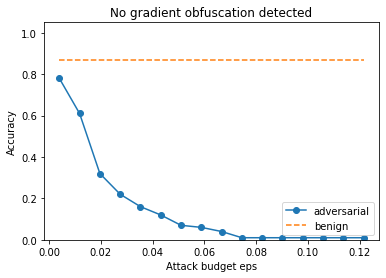

In [30]:
classifier = KerasClassifier(model=model_clone, clip_values=(0, 1))

kwargs_pgd = {"norm": "inf",
              "eps_step": 1/255,
              "max_iter": 100,
              "targeted": False,
              "num_random_init": 0,
              "batch_size": 128,
              "random_eps": False,
              "verbose": False,
             }

sc = SecurityCurve(eps=[i / 255 for i in range(1, 32, 2)])
eps_list, accuracy_adv_list, accuracy = sc.evaluate(classifier=classifier,
                                                    x=x_test[0:100],
                                                    y=np.eye(np.max(y_test)+1)[y_test][0:100],
                                                    **kwargs_pgd)
sc.plot()